# Uncovering the phylogeny of Hox proteins

The goal of this notebook was to analyze the evolution of [Hox genes](https://en.wikipedia.org/wiki/Hox_gene). These genes play a role in morphological development in a wide range of animals (including human), i.e. they control the body plan of an embryo along the head-tail axis.

## Inferring the gene tree

Our dataset consits of 101 sequences coding for genes from Hox family. The first step of the analysis is to reconstruct the gene tree of these genes based on the similarity of our sequences.

In [82]:
%reload_ext autoreload
%autoreload 2
from tqdm import tqdm
from itertools import groupby
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import SeqIO, SearchIO
import utils
from trees import Node, label_with_species, label_with_parents, \
label_nonterminal_clade_with_species, reconcile, compute_deep_coalescence, find_duplications

In [2]:
FILE_PATH = 'homeo2.fa'

In [84]:
all_sequences = list(SeqIO.parse('homeo2.fa', format='fasta'))
hox_sequences = list(filter(lambda seq: seq.id.split('|')[2].lower().startswith('hox'), all_sequences))

In [4]:
len(hox_sequences), len(all_sequences)

(101, 839)

In [5]:
hox_sequences[:3]

[SeqRecord(seq=Seq('RRRGRQTYTRFQTLELEKEFHFNHYLTRRRRIEIAHALCLTERQIKIWFQNRRMKLKKEL', SingleLetterAlphabet()), id='Fruitfly|abd-A|Hox6-8|ANTP', name='Fruitfly|abd-A|Hox6-8|ANTP', description='Fruitfly|abd-A|Hox6-8|ANTP', dbxrefs=[]),
 SeqRecord(seq=Seq('RRRGRQTYTRFQTLELEKEFHFNHYLTRRRRIEIAHALCLTERQIKIWFQNRRMKLKKEL', SingleLetterAlphabet()), id='Beetle|abd-A|Hox6-8|ANTP', name='Beetle|abd-A|Hox6-8|ANTP', description='Beetle|abd-A|Hox6-8|ANTP', dbxrefs=[]),
 SeqRecord(seq=Seq('VRKKRKPYSKFQTLELEKEFLFNAYVSKQKRWELARNLQLTERQVKIWFQNRRMKNKKNS', SingleLetterAlphabet()), id='Fruitfly|Abd-B|Hox9-13(15)|ANTP', name='Fruitfly|Abd-B|Hox9-13(15)|ANTP', description='Fruitfly|Abd-B|Hox9-13(15)|ANTP', dbxrefs=[])]

For estimating similarity scores between each pair of sequences we shall use BLAST hit scores against whole set of 839 sequences.

In [6]:
!makeblastdb -in {FILE_PATH} -dbtype prot -out db -title "myHOXdb"



Building a new DB, current time: 06/21/2018 16:17:59
New DB name:   /Users/tomek/workspace/wbo/zad2/db
New DB title:  myHOXdb
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/tomek/workspace/wbo/zad2/db
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 839 sequences in 0.0382659 seconds.


In [7]:
score_matrix = utils.make_score_matrix(hox_sequences)

100%|██████████| 101/101 [00:40<00:00,  2.49it/s]


In [8]:
print(score_matrix)

Fruitfly|abd-A|Hox6-8|ANTP	0
Beetle|abd-A|Hox6-8|ANTP	119.783	0
Fruitfly|Abd-B|Hox9-13(15)|ANTP	78.1814	78.1814	0
Beetle|Abd-B|Hox9-13(15)|ANTP	78.5666	78.5666	116.316	0
Fruitfly|Antp|Hox6-8|ANTP	110.538	110.538	73.1738	73.559	0
Fruitfly|bcd|Hox3|ANTP	46.595	46.595	45.0542	45.4394	48.1358	0
Beetle|Cx|Hox5|ANTP	102.834	102.834	73.9442	74.3294	110.923	49.2914	0
Fruitfly|Dfd|Hox4|ANTP	90.5077	90.5077	68.5514	68.5514	100.908	55.4546	103.99	0
Beetle|Dfd|Hox4|ANTP	90.5077	90.5077	68.5514	68.5514	100.908	55.4546	103.99	122.094	0
Fruitfly|ftz|Hox6-8|ANTP	98.9821	98.9821	76.2554	76.6406	102.834	53.1434	99.7525	93.9745	93.9745	0
Beetle|ftz|Hox6-8|ANTP	98.2117	98.2117	78.5666	78.1814	100.523	48.9062	97.0561	92.4337	92.4337	104.76	0
Human|HOXA1|Hox1|ANTP	73.9442	73.9442	62.7734	60.8474	75.0998	58.151	78.1814	80.1073	80.1073	75.8702	78.9518	0
Mouse|Hoxa1|Hox1|ANTP	72.0182	72.0182	62.003	59.6918	73.559	56.6102	76.6406	78.1814	78.1814	73.9442	77.411	119.398	0
Human|HOXA10|Hox9-13(15)|ANTP	79.7221	79.

Then a tree will be constructed using neighbor joing algorithm.

In [9]:
gene_tree = utils.make_tree(score_matrix)

## Reconciling the gene tree with a species tree

The next step of our analysis is to assume a particular topology of a species tree and reconcile it with inferred gene tree. Reconcilation here means mapping each gene tree node $g$ to a species tree node $s$ such that all $g$ non-terminal are a subset of $s$ non-terminals. Non-terminals here correspond to particular species (human, fruitfly, beetle or mouse).

In [10]:
species_tree = Node(
    children=[Node(
                children=[Node(species='Beetle'), 
                          Node(species='Fruitfly')]
             ),
             Node(
                 children=[Node(species='Human'), 
                           Node(species='Mouse')]
             )]
)

In [11]:
label_with_species(gene_tree)
label_with_parents(gene_tree)
for clade in species_tree.get_nonterminals():
    label_nonterminal_clade_with_species(clade)

In [12]:
reconcile(species_tree, gene_tree)

Clade --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner97 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner95 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner92 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner80 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner71 --> Node(species={'Mouse'})
Inner14 --> Node(species={'Mouse'})
Inner24 --> Node(species={'Mouse'})
Inner56 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner50 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner5 --> Node(species={'Human'})
Inner72 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner54 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner7 --> Node(species={'Human'})
Inner21 --> Node(species={'Mouse'})
Inner90 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner79 --> Node(species={'Mouse', 'Beetle', 'Fruitfly', 'Human'})
Inner70 --> Node(species={'Mouse', 'Beetle', 'Fruit

Then, let us compute deep coalescence score (a measure of how well gene tree and species tree align) and the number of duplications predicted by the inferred reconcilation.

In [13]:
compute_deep_coalescence(species_tree, gene_tree)

151

In [14]:
duplications = find_duplications(gene_tree)

In [15]:
duplications

{Clade(branch_length=2.0412203124999997, name='Inner55'),
 Clade(branch_length=0.29315160217285086, name='Inner91'),
 Clade(branch_length=0.3393534863281261, name='Inner90'),
 Clade(branch_length=1.67499375, name='Inner57'),
 Clade(branch_length=0.17529246520996056, name='Inner93'),
 Clade(branch_length=0.1728577524038486, name='Inner85'),
 Clade(branch_length=1.9156389453124985, name='Inner56'),
 Clade(branch_length=0),
 Clade(branch_length=2.051498437499998, name='Inner58'),
 Clade(branch_length=1.25689122721354, name='Inner69'),
 Clade(branch_length=1.4125409040178591, name='Inner67'),
 Clade(branch_length=0.4966016601562495, name='Inner82'),
 Clade(branch_length=0.06062388184856771, name='Inner98'),
 Clade(branch_length=0.3041105468750005, name='Inner83'),
 Clade(branch_length=1.2047831380208378, name='Inner62'),
 Clade(branch_length=0.2994389729817697, name='Inner87'),
 Clade(branch_length=3.369485611979164, name='Inner45'),
 Clade(branch_length=1.6576284179687506, name='Inner60')

In [16]:
len(duplications)

44

Let us plot the gene tree with marked duplications. Duplication events are marked with stars. We can observe that then all occur neat the root of the tree.

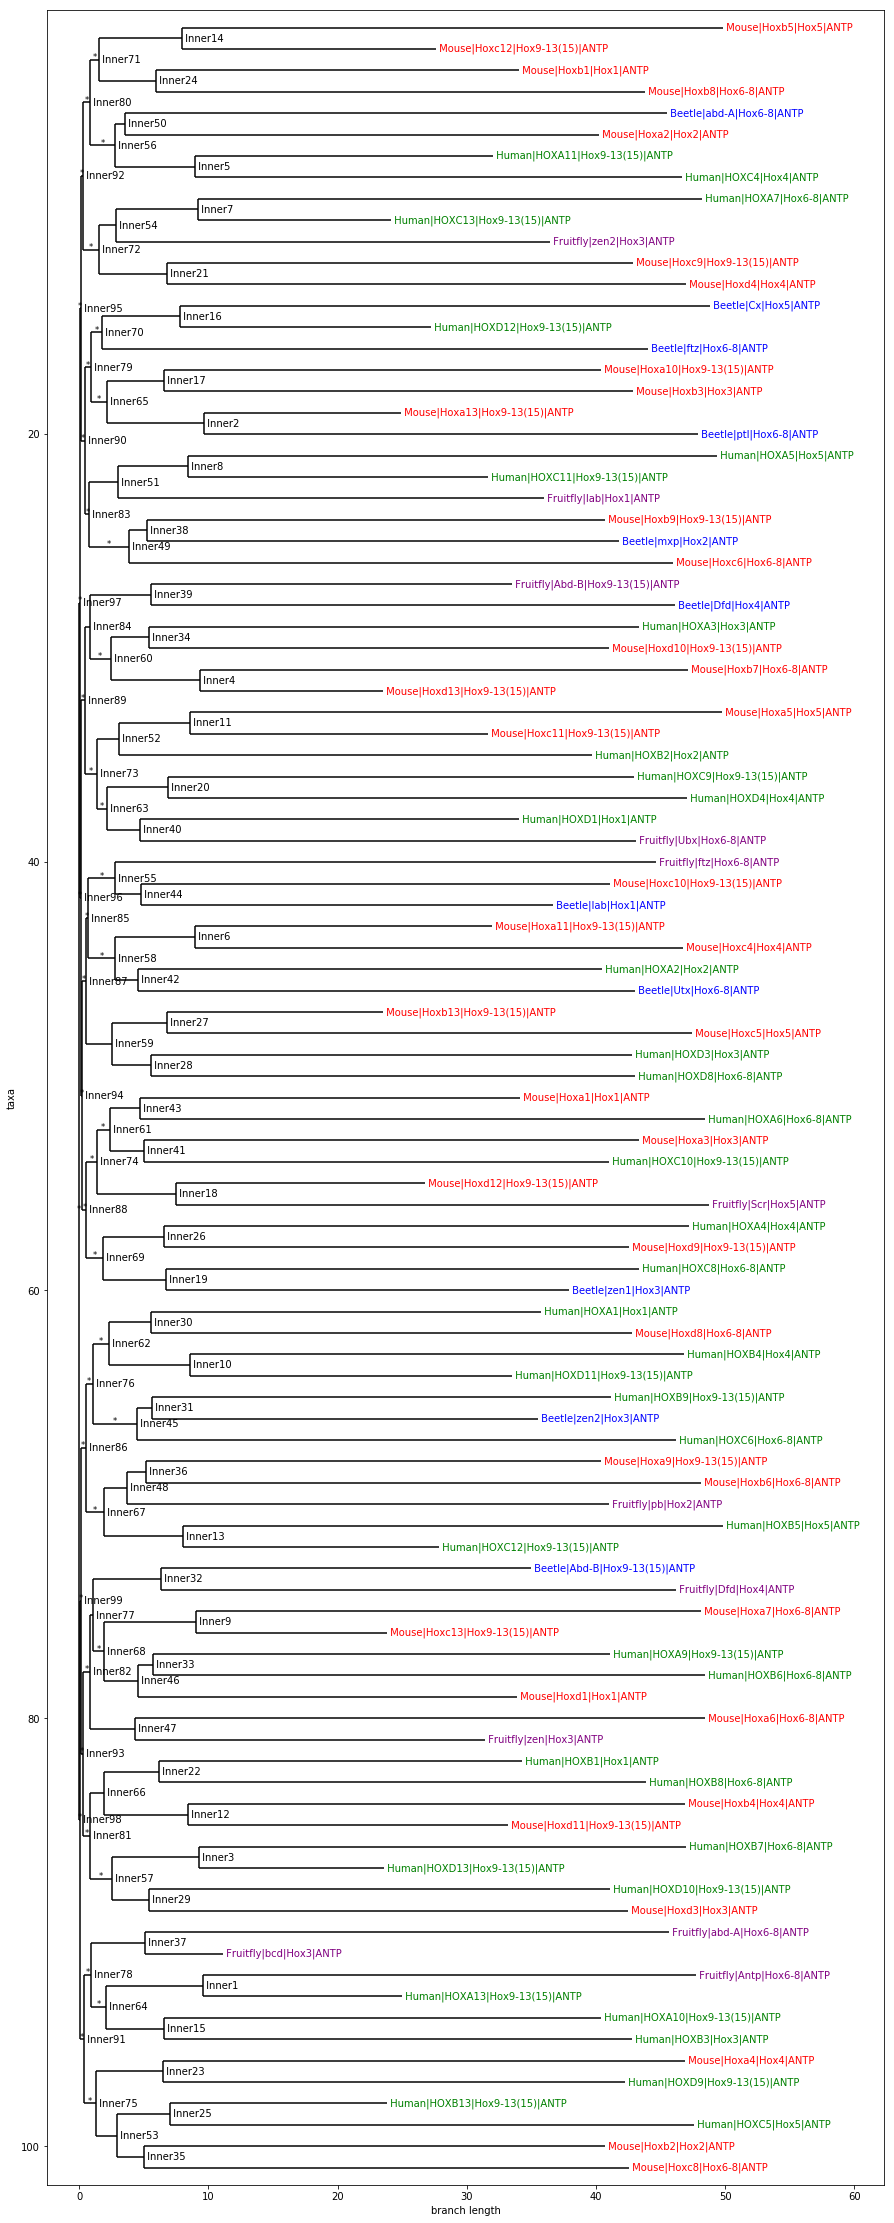

In [17]:
utils.draw_tree(gene_tree, duplications)

# Protein domain analysis

The last task we turn to is protein domain analysis in gene classes in our subset. We will user HMMer to compute the number the score between each pair of gene classes.

In [172]:
all_sequences = list(SeqIO.parse('homeo2.fa', format='fasta'))
groups = [group for group, _ in groupby(all_sequences, lambda seq: seq.id.split('|')[-1])]
scores = np.zeros((len(groups), len(groups))) 

In [177]:
i, j = 0, 0
for group_a, subset_a_it in tqdm(groupby(all_sequences, lambda seq: seq.id.split('|')[-1])):
    subset_a = list(subset_a_it)
    i = 0
    for group_b, subset_b_it in groupby(all_sequences, lambda seq: seq.id.split('|')[-1]):
        subset_b = list(subset_b_it)
        SeqIO.write(subset_a, 'sequences_subset_a.fasta', 'fasta')
        SeqIO.write(subset_b, 'sequences_subset_b.fasta', 'fasta')
        _ = !hmmbuild sequences_db.hmm sequences_subset_a.fasta
        search_results = !hmmsearch sequences_db.hmm sequences_subset_b.fasta
        scores[i, j] = extract_score_from_hmmer(search_results)
#         print(f'Matching {group_a} with {group_b} with score {score}')
        i += 1
    j += 1



0it [00:00, ?it/s]
128it [25:55,  9.33s/it]


In [156]:
def extract_score_from_hmmer(search_results):
    try:
        return float(search_results[14].split()[1])
    except IndexError:
        return 0

In [182]:
scores

array([[130.2,  22.4,   0. , ...,   0. ,  96.8,  39.9],
       [ 22. , 166.5,   0. , ...,   0. ,  15.1,  22.7],
       [ 24. ,   0. ,   0. , ...,   0. ,  19.8,  48.7],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,  38.3],
       [ 97.6,  14.5,   0. , ...,   0. , 138.9,  48.4],
       [ 35.4,  19.6,   0. , ...,   0. ,  36.2,  92.6]])

We have obtain a 128x128 matrix of scores for each family pair. Let us visualize a heatmap of this matrix.

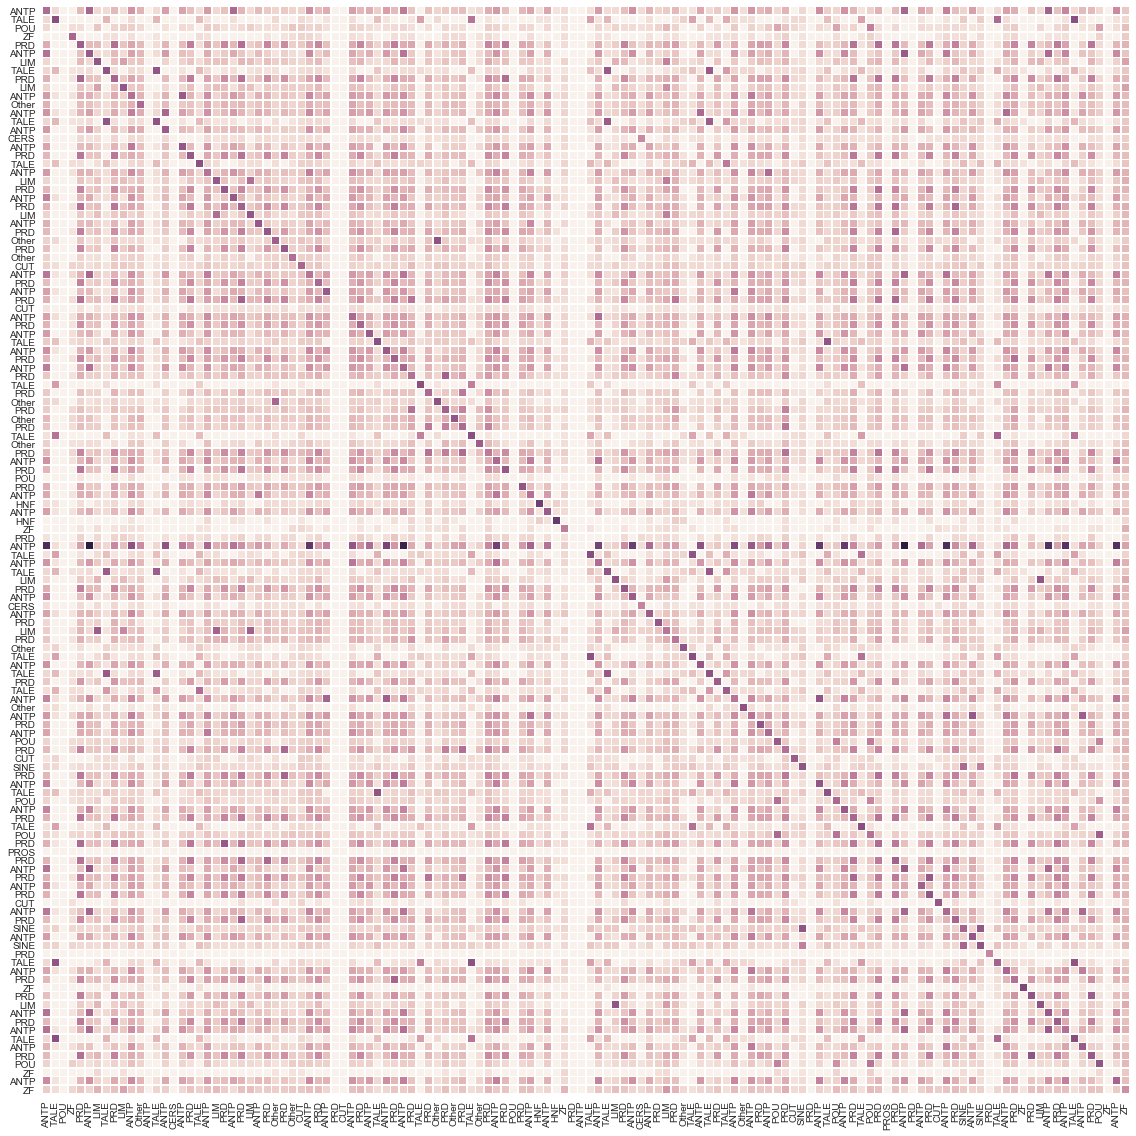

In [178]:
%matplotlib inline
sns.heatmap(scores, square=True, yticklabels=groups, xticklabels=groups, 
                      annot=False, linewidths=.5, cbar=False)